# Kaggle YouTube-8M Video Classification
## An Overview of 1st-place solution Network Architecture (NETVLAD)
### [Team WILLOW open-sourced solution](https://arxiv.org/pdf/1706.06905.pdf) 
 ---

### This is my attempt to learn from the first-place solution of the video classification challenge.

- [Problem Description](#problem-description)
  - [Exploratory Data Analysis](#exploratory-data-analysis)
- [My initial approach](#my-initial-approach)
- [First place solution](#first-place-solution) 

## Loading data

The code is referenced from this [kernel](https://www.kaggle.com/wendykan/starter-explore-youtube8m-sample-data)

In [1]:
import pandas as pd
import tensorflow as tf
from IPython.display import YouTubeVideo
import numpy as np
import glob
import seaborn as sbn
import matplotlib.pyplot as plt

In [2]:
video_lvl_record = "data/yt8m/video_level/train45.tfrecord"

vid_ids = []
labels = []
mean_rgb = []
mean_audio = []

for example in tf.python_io.tf_record_iterator(video_lvl_record):
    tf_example = tf.train.Example.FromString(example)

    vid_ids.append(tf_example.features.feature['video_id'].bytes_list.value[0].decode(encoding='UTF-8'))
    labels.append(tf_example.features.feature['labels'].int64_list.value)
    mean_rgb.append(tf_example.features.feature['mean_rgb'].float_list.value)
    mean_audio.append(tf_example.features.feature['mean_audio'].float_list.value)

In [3]:
labels_mapping = pd.Series.from_csv('data/label_names.csv',header=0).to_dict()
labels_df = pd.read_csv('data/label_names.csv')

In [ ]:
filenames = glob.glob('data/yt8m/video_level/*.tfrecord')[:10]
total_sample_counter = 0

label_length = {}

for file in filenames:
    for example in tf.python_io.tf_record_iterator(file):
        total_sample_counter += 1
        
        tf_example = tf.train.Example.FromString(example)
        
        vid_id = tf_example.features.feature['video_id'].bytes_list.value[0].decode(encoding='UTF-8')
        labels = tf_example.features.feature['labels'].int64_list.value
        
        label_length[vid_id] = labels

In [ ]:
label_all_name = []
label_name = []
for labels in list(label_length.values()):
    names = list(labels_df[labels_df['label_id'].isin(list(labels))]['label_name'])
    label_all_name += names
    label_name.append(names)

## <a id='problem-description'></a>Problem Description

**Here's a brief overview of the problem:**

- About 8 Million videos - hence **8M** 
- About 4716 unique tags
- Each video can have between 1 - 15 unique tags assigned


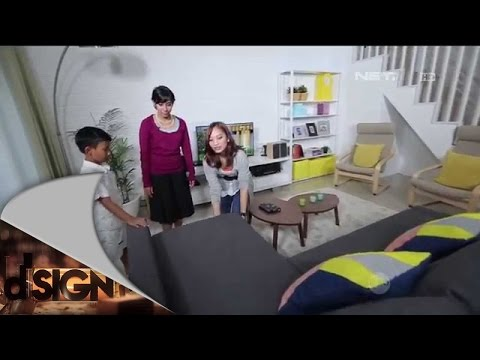

In [4]:
def play_one_vid(record_name, video_index):
    return vid_ids[video_index]
    
labels_10 = [labels_mapping[label] for label in labels[10]]
YouTubeVideo(play_one_vid(video_lvl_record, 10))

This video has the following labels: **Living room, room, IKEA, Furniture**

## <a id='exploratory-data-analysis'></a> Exploratory Data Analysis

I'll only focus on certain aspects of the data that I think inspires the network architecture of the winning solution.

The code is referenced from this [kernel](https://www.kaggle.com/philschmidt/youtube8m-eda)

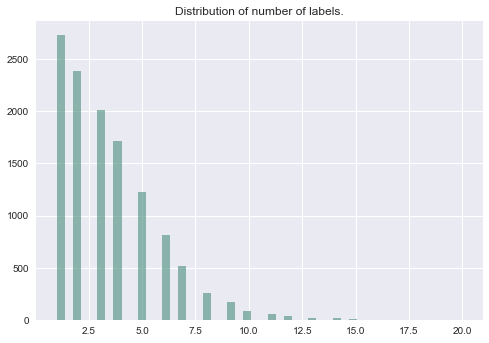

In [15]:
lengths = [len(labels) for labels in list(label_length.values())]

sbn.distplot(lengths, kde=False)
plt.title("Distribution of number of labels.")
plt.show()

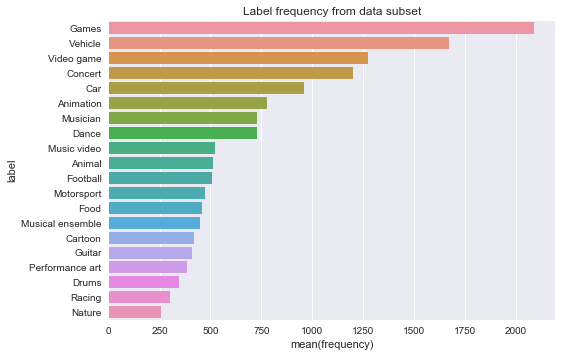

In [32]:
test = pd.DataFrame({'label' : label_all_name}).groupby('label').size().rename('frequency')
test = pd.DataFrame(test)
test = test.sort_values('frequency', ascending=False).reset_index()

sbn.barplot(x='frequency', y='label', data=test.iloc[0:20, :])
plt.title('Label frequency from data subset')
plt.show()

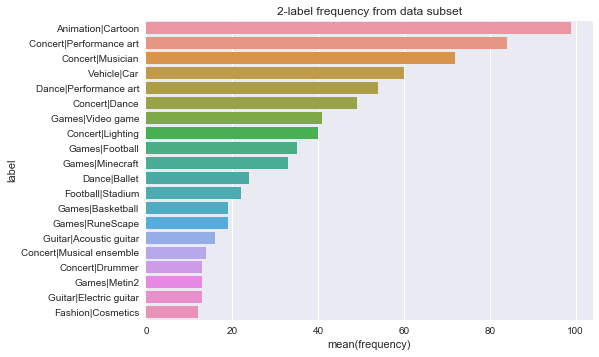

In [34]:
two_element_labels = ['|'.join(list(x)) for x in label_name if len(x) == 2]
test_2 = pd.DataFrame({'label' : two_element_labels}).groupby('label').size().rename('frequency')
test_2 = pd.DataFrame(test_2)
test_2 = test_2.sort_values('frequency', ascending=False).reset_index()

plt.title("2-label frequency from data subset")
sbn.barplot(x="frequency", y='label', data=test_2.iloc[0:20, :])
plt.show()

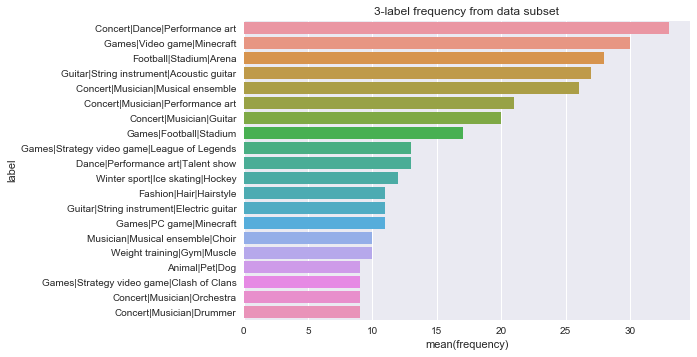

In [35]:
three_element_labels = ['|'.join(list(x)) for x in label_name if len(x) == 3]

test_3 = pd.DataFrame({'label' : three_element_labels}).groupby('label').size().rename('frequency')
test_3 = pd.DataFrame(test_3)
test_3 = test_3.sort_values('frequency', ascending=False).reset_index()

sbn.barplot(x="frequency", y='label', data=test_3.iloc[0:20, :])
plt.title('3-label frequency from data subset')
plt.show()

As we can see from the above plots, different labels have very different frequency distributions. The co-occurence of labels is definitely **NOT** uniform, some combinations are more likely than others, for example Animation|Cartoons or Concert|Performance art, etc.

Additionally, video with only 1 label is the most common, and videos with more than 1 labels are increasingly less. 

***Thus the co-occurence of labels, label frequencies and the number of labels can be taken advantage of when designing the network architecture.***

## <a id='my-initial-approach'></a> My Initial Approach

This approach is inspired by the [YouTube-8M Technical Report](https://arxiv.org/pdf/1609.08675.pdf)

- The paper proposes that using ordinal statistics features would increase performance. However the implementation was missing from the [provided code](https://github.com/google/youtube-8m/#overview-of-models). I implemented it on top of the code base and achieved a score of **0.78125**, 224/650 teams on the leaderboard.


- For frame-level input, the model input has shape **[batch_size, num_frames, 1152]** for both frame and audio features. 

$$\begin{bmatrix}\mu(x_{1:F_v}^{v})\\\sigma(x_{1:F_v}^{v})\\Top_k(x_{1:F_v}^{v})\end{bmatrix}$$

- $\mu(x_{1:F_v}^{v})$ : is the mean, has shape [batch_size, 1, 1152]
- $\sigma(x_{1:F_v}^{v})$ : is the standard deviation, has shape [batch_size, 1, 1152]
- $Top_k(x_{1:F_v}^{v})$ : represents the K highest values of each dimension over every frame, has shape [batch_size, K, 1152]

Concatenation of all these features gives an input of shape **[batch_size, (K+2) * 1152]**

Implementation in Tensorflow:

``` 
mean, var = tf.nn.moments(video_matrix, axes=[0])
ordinal_5_stats, _ = tf.nn.top_k(tf.transpose(video_matrix), k=5)
ordinal_5_stats = tf.transpose(ordinal_5_stats)
all_features = tf.concat([tf.expand_dims(mean, 0), tf.expand_dims(var, 0), ordinal_5_stats], axis=0)
batch_all_features = tf.reshape(all_features, [1, -1])
```


## <a id='first-place-solution'></a> First-place Solution

For this challenge, the data pipeline consists of 3 main steps:

1. **Feature extraction**: the provided data is already pre-processed and packaged in TFRecord format. More information on how this is done is available here [YouTube-8M Technical Report](https://arxiv.org/pdf/1609.08675.pdf).

2. **Feature aggregation**: this is one of the main contribution of the First-place solution. Given multiple frames from a video, how do we aggregate multiple frames into video-level feature set for classification.

3. **Clasifier**: we'll go into more detail below.


*The final solution consists of an ensemble of 25 different models, in this post I will only focus on one model architecture which has the best individual performance.*

### Feature Aggregation

The best performing Aggregator as shown in the paper is **NetVLAD** (Vector of Locally Aggregated Descriptors). NetVLAD works as follows:

Given input including both video and audio features, which has shape: [batch_size, num_frames, 1152]
        

$$V(j, k) = \sum_{i=1}^{numframes} \frac{e^{w_{k}^{T}x_i + b_k}}{\sum_{k'} e^{w_{k'}^{T}x_i + b_{k'}}} [x_{i}^j - c_{k}(j)] $$

where {$w_{k}$}, {$b_{k}$}, {$c_{k}$} are learnable parameters, trained for the specific task in an end-to-end manner. $x_{i}^j$ means feature `j` of frame `i`, and $c_{k}(j)$ represents feature `j` of cluster `k`. Output `V` is then normalized using L2-normalization, and has shape [batch_size, K, 1152] 

- {$w_{k}$}: trainable weights, has shape [num_frames, K]
- {$b_{k}$}: trainable biases, has shape [1152]
- {$c_{k}$}: trainable cluster, has shape [K, 1152]
- K: hyperparameter, number of clusters


### Context Gating

The paper proposes a unit layer called Context Gating, which transform the input representation while retaining its shape:

$$Y = (XW + b) \circ X$$

- The $\circ$ notation indicates element-wise product. `W` and `b` are trainable parameters, initialized to be between 0 and 1. This layer according to the paper helps capture dependencies between input features. 
- The Context Gating layer is applied to the aggregated features, before feeding it to the classifier (which is a Mixture of Experts model). It's also applied to the logits output of the classifier, to capture the structure of the output label space.


=> **It makes intuitive sense that the Context Layer captures dependencies between input features, such as 'background' and 'foreground'. However I find it insightful that the Context Layer can also capture dependencies between labels. As shown above in our analysis, label co-occurences can vary a lot depending on the labels (some label combinations are more likely than others) and this Context Gating layer helps 'regularize' the output label probabilities to take that into account. **